# EXPLORATION
# 14. 난 스케치를 할 테니 너는 채색을 하거라 [프로젝트]

In [ ]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/aiffel/aiffel_project/data/conditional_generation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/aiffel/aiffel_project/data/conditional_generation


## 14-1. 프로젝트: Segmentation map으로 도로 이미지 만들기

### 데이터 불러오기

number of train examples : 1000


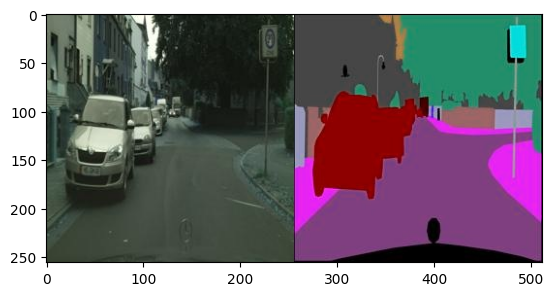

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

data_path = 'data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

f = data_path + os.listdir(data_path)[np.random.randint(1000)]
img = cv2.imread(f, cv2.IMREAD_COLOR)
plt.imshow(img)

In [ ]:
img.shape

(256, 512, 3)

이미지를 256 * 256 * 3 크기의 이미지 두 장으로 나누면 되겠습니다.

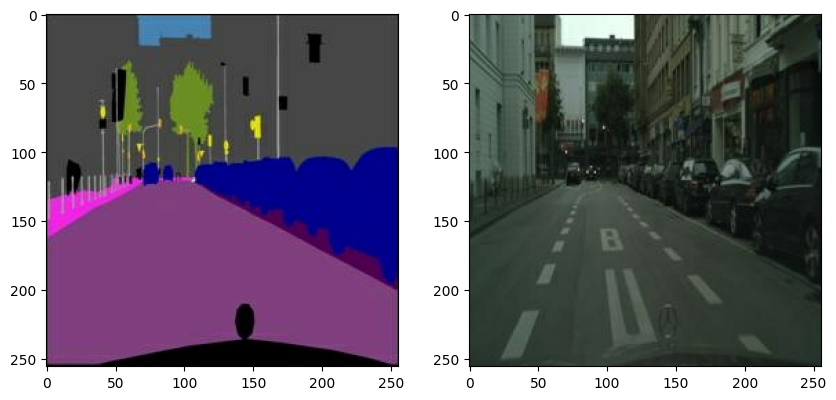

In [ ]:
import tensorflow as tf

def normalize(x):   # 픽셀 색상값 normalize
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x): # 픽셀 색상값 denormalize
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    picture = img[:, :w, :] 
    picture = tf.cast(picture, tf.float32)  # 왼쪽이 실제 사진
    seg_img = img[:, w:, :] 
    seg_img = tf.cast(seg_img, tf.float32)  # 오른쪽이 segmentation된 이미지
    return normalize(seg_img), normalize(picture)

f = data_path + os.listdir(data_path)[1]
seg_img, picture = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg_img))
plt.subplot(1,2,2); plt.imshow(denormalize(picture))

## 1. 데이터에 한 가지 이상의 **augmentation 방법을 적용**하여 학습해주세요.  
## (어떠한 방법을 사용했는지 적어주세요.) 

사용한 augmentation 방법


1. 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다.
2. (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다.
3. 50% 확률로 가로로 뒤집습니다.
4. 50% 확률로 세로로 뒤집습니다.
5. 50% 확률로 회전시킵니다.

In [ ]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(seg_img, picture):
    stacked = tf.concat([seg_img, picture], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        # 50퍼센트 확률로 reflection padding이 30픽셀의 padwith만큼 적용됩니다.
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        # 50퍼센트 확률로 constant padding이 30픽셀의 padwith만큼 적용됩니다.
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    # 256, 256, 6 크기를 가진 이미지를 임의로 잘라냅니다.
    out = image.random_crop(padded, size=[256, 256, 6]) 
    
    # 50퍼센트 확률로 horizontal_flip시킵니다.
    out = image.random_flip_left_right(out) 
    
    # 50퍼센트 확률로 vertical_flip시킵니다.
    out = image.random_flip_up_down(out)    
    
    #   50퍼센트 확률로 반시계 방향으로 90 * (1~3)도 회전시킵니다.
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        degree = tf.cast(degree / 90, tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

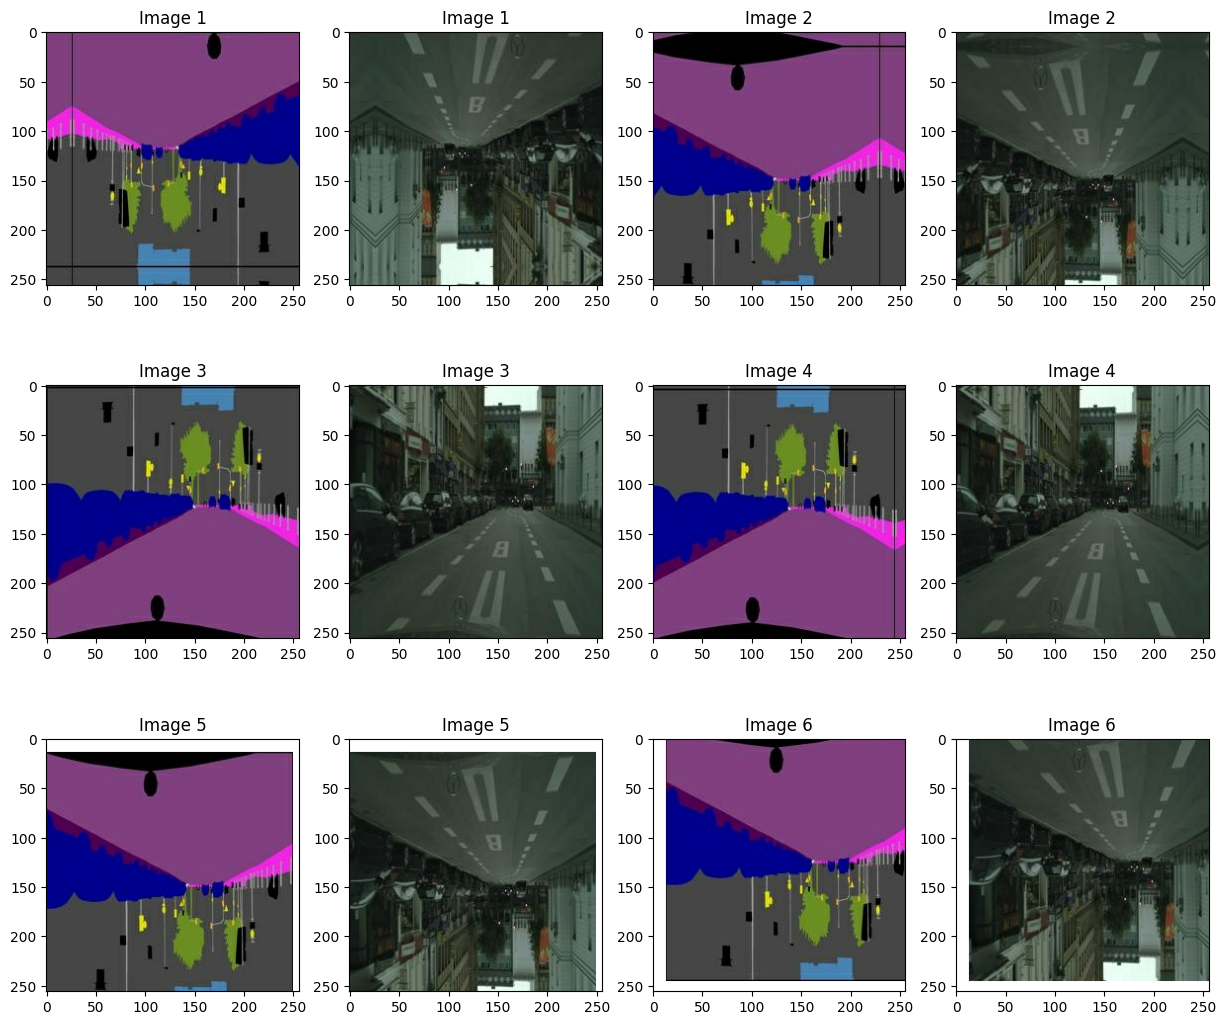

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_seg_img, augmented_picture = apply_augmentation(seg_img, picture)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_seg_img)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_picture)); plt.title(f"Image {img_n}")
    img_n += 1

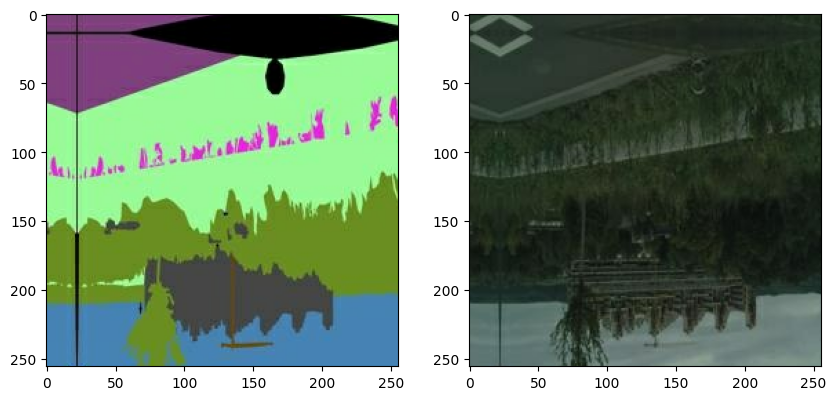

In [ ]:
from tensorflow import data

def get_train(img_path):
    _seg_img, _picture = load_img(img_path)
    _seg_img, _picture = apply_augmentation(_seg_img, _picture)
    return _seg_img, _picture

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
seg_img, picture = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(seg_img[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(picture[0].astype(np.uint8))

## 2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 **U-Net Generator를 사용**해 주세요.

### Generator 구성하기

In [ ]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [ ]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        # Skip connection에서 Encoder의 마지막 출력은 Decoder로 직접 입력되기 때문에 [:-1]로 인덱싱
        features = features[:-1]
        
        # Encoder와 Decoder를 서로 대칭되는 형태로 연결시키기 위해 역순으로 연결
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

### Discriminator 구현하기

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        for i, n_filters in enumerate(filters):
            stride = 2 if i < 3 else 1
            padding = False if i < 3 else True
            use_bn  = False if i == 0 or i == 4 else True
            act = True if i < 4 else False
            self.blocks.append(DiscBlock(n_filters, stride, padding, use_bn, act))

        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x, y):
        out = self.blocks[0]([x, y])
        for block in self.blocks[1:]:
            out = block(out)
        
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [ ]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

### Model 학습하기

In [ ]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [ ]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [ ]:
generator = UNetGenerator()
discriminator = Discriminator()

@tf.function()
def train_step(seg_img, picture):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(seg_img)
        
        real_out = discriminator(seg_img, picture)
        fake_disc = discriminator(seg_img, fake_images)

        gene_loss, l1_loss = get_gene_loss(fake_images, picture, fake_disc)
        disc_loss = get_disc_loss(fake_disc, real_out)

    gene_gradient = gene_tape.gradient(gene_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 100

for epoch in range(1, EPOCHS+1):
    for i, (seg_img, picture) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(seg_img, picture)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
EPOCH[61] - STEP[10]                     
Generator_loss:1.0439                     
L1_loss:0.2090                     
Discriminator_loss:1.0250

EPOCH[61] - STEP[20]                     
Generator_loss:1.0067                     
L1_loss:0.2657                     
Discriminator_loss:1.0740

EPOCH[61] - STEP[30]                     
Generator_loss:0.8548                     
L1_loss:0.2270                     
Discriminator_loss:0.9262

EPOCH[61] - STEP[40]                     
Generator_loss:0.9163                     
L1_loss:0.2046                     
Discriminator_loss:0.8646

EPOCH[61] - STEP[50]                     
Generator_loss:0.9814                     
L1_loss:0.2479                     
Discriminator_loss:0.8818

EPOCH[61] - STEP[60]                     
Generator_loss:0.9135                     
L1_loss:0.2329                     
Discriminator_loss:1.0981

EPOCH[61] - STEP[70]                     
Generator_loss:0.7763             

## 3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.

In [ ]:
test_ind = 3

data_path = 'data/cityscapes/val/'
f = data_path + os.listdir(data_path)[test_ind]
seg_img, picture = load_img(f)

pred = generator(tf.expand_dims(seg_img, 0))
pred = denormalize(pred)

## 4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.

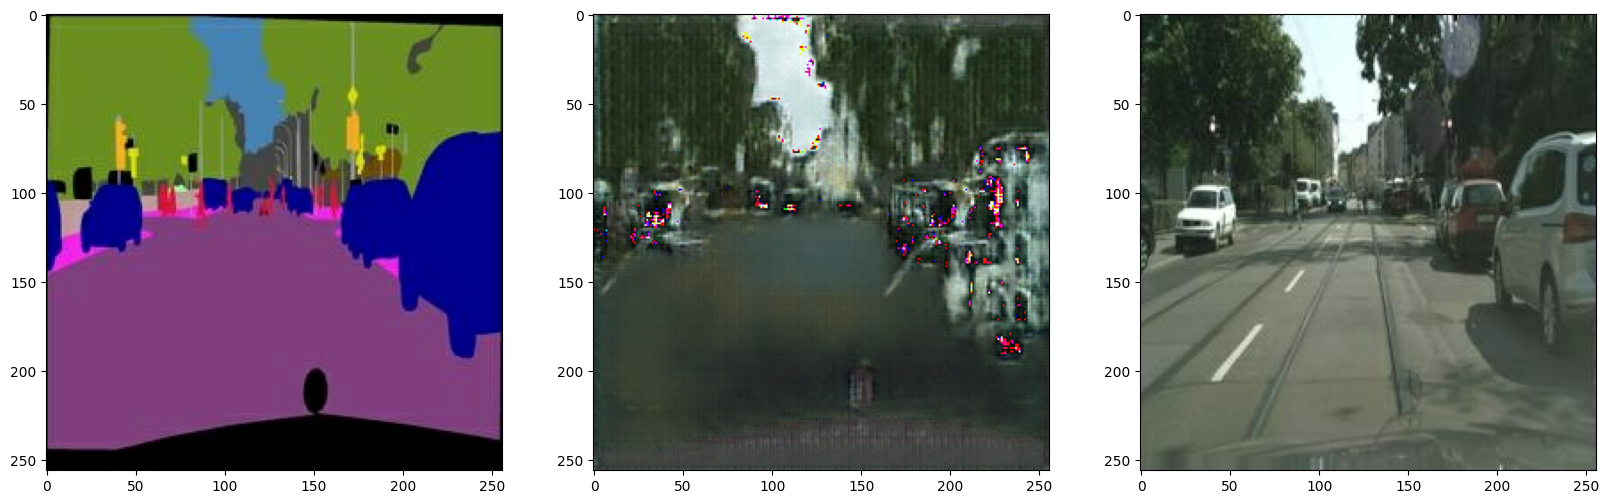

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(seg_img))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(picture))

노드 학습 시 진행한 10 epoch에 비해 생성된 사진에서 어느 정도 실제 사진(정답)의 형태가 보이는 것을 확인할 수 있습니다.

## 5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

EPOCH[100] - STEP[210]                     
Generator_loss:0.8501                     
L1_loss:0.2850                     
Discriminator_loss:1.1479

EPOCH[100] - STEP[220]                     
Generator_loss:0.8963                     
L1_loss:0.2082                     
Discriminator_loss:1.4096

EPOCH[100] - STEP[230]                     
Generator_loss:0.7608                     
L1_loss:0.2339                     
Discriminator_loss:1.4335

EPOCH[100] - STEP[240]                     
Generator_loss:0.7255                     
L1_loss:0.2183                     
Discriminator_loss:1.2930

EPOCH[100] - STEP[250]                     
Generator_loss:1.0163                     
L1_loss:0.2818                     
Discriminator_loss:1.1597

100 epoch의 마지막 부분입니다.